In [1]:
library(tidyverse)
library(RColorBrewer)
library(DESeq2)
library(pheatmap)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The follow

In [2]:
setwd('/ufrc/soltis/shan158538/TragFL_NewAnalysis/OutPut/DE_analysis/DE_Tms_Tml')

In [5]:
## Loading data
data <- read.table("DESeq2_count_matrix_Tml_Tms.csv", sep=",",header = T,row.names=1)
meta <- read.csv("DESeq2_Tml_Tms_sample_annotation.tsv", sep = "\t", row.names="sample")
## first column is row names: row.names = 1

In [6]:
head(data)

,Tml_1,Tml_2,Tml_3,Tms_1,Tms_2,Tms_3
,<int>,<int>,<int>,<int>,<int>,<int>
Tpr_TRINITY_DN11257_c2_g1|Tdu_TRINITY_DN16696_c0_g1,71,58,79,63,65,63
Tpr_TRINITY_DN10844_c2_g7|Tdu_TRINITY_DN25328_c2_g5,135,137,111,130,154,195
Tpr_TRINITY_DN15383_c4_g16|Tdu_TRINITY_DN14160_c0_g1,26,20,9,11,30,21
Tpr_TRINITY_DN1451_c0_g1|Tdu_TRINITY_DN16990_c3_g1,71,38,47,32,43,76
Tpr_TRINITY_DN10853_c1_g4|Tdu_TRINITY_DN21860_c3_g3,437,337,388,362,405,497
Tpr_TRINITY_DN12798_c2_g2|Tdu_TRINITY_DN24179_c2_g3,7,49,58,84,40,93


In [7]:
meta

,species
,<fct>
Tml_1,Tml
Tml_2,Tml
Tml_3,Tml
Tms_1,Tms
Tms_2,Tms
Tms_3,Tms


## 1. RNA-seq count distribution
### To determine the appropriate statistical model, we need information about the distribution of counts.

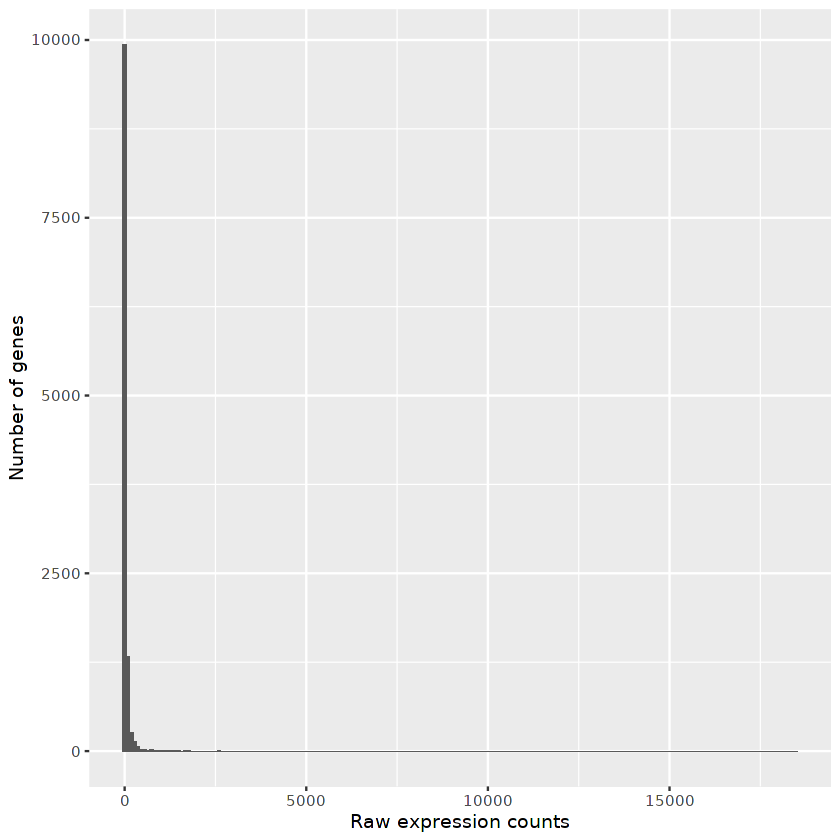

In [8]:
## Here showed read counts distribution of sample Tml_1
ggplot(data) +
  geom_histogram(aes(x = Tml_1), stat = "bin", bins = 200) +
  xlab("Raw expression counts") +
  ylab("Number of genes")

These images illustrate some common features of RNA-seq count data, including a low number of counts associated with a large proportion of genes, and a long right tail due to the lack of any upper limit for expression.

## 2. Moduling count data
### 1) binomial distribution; used in situations when you have a certain number of cases; not suitable for RNA-seq data
### 2) Poisson distribution; However, a unique property of this distribution is that the mean == variance
### 3) **Negative Binomial (NB) model**; the NB model is a good approximation for data where the mean < variance, as is the case with RNA-Seq count data

Plot the mean versus the variance of your data

In [11]:
head(data[, 1:3])
## indicates Tml data

,Tml_1,Tml_2,Tml_3
,<int>,<int>,<int>
Tpr_TRINITY_DN11257_c2_g1|Tdu_TRINITY_DN16696_c0_g1,71,58,79
Tpr_TRINITY_DN10844_c2_g7|Tdu_TRINITY_DN25328_c2_g5,135,137,111
Tpr_TRINITY_DN15383_c4_g16|Tdu_TRINITY_DN14160_c0_g1,26,20,9
Tpr_TRINITY_DN1451_c0_g1|Tdu_TRINITY_DN16990_c3_g1,71,38,47
Tpr_TRINITY_DN10853_c1_g4|Tdu_TRINITY_DN21860_c3_g3,437,337,388
Tpr_TRINITY_DN12798_c2_g2|Tdu_TRINITY_DN24179_c2_g3,7,49,58


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


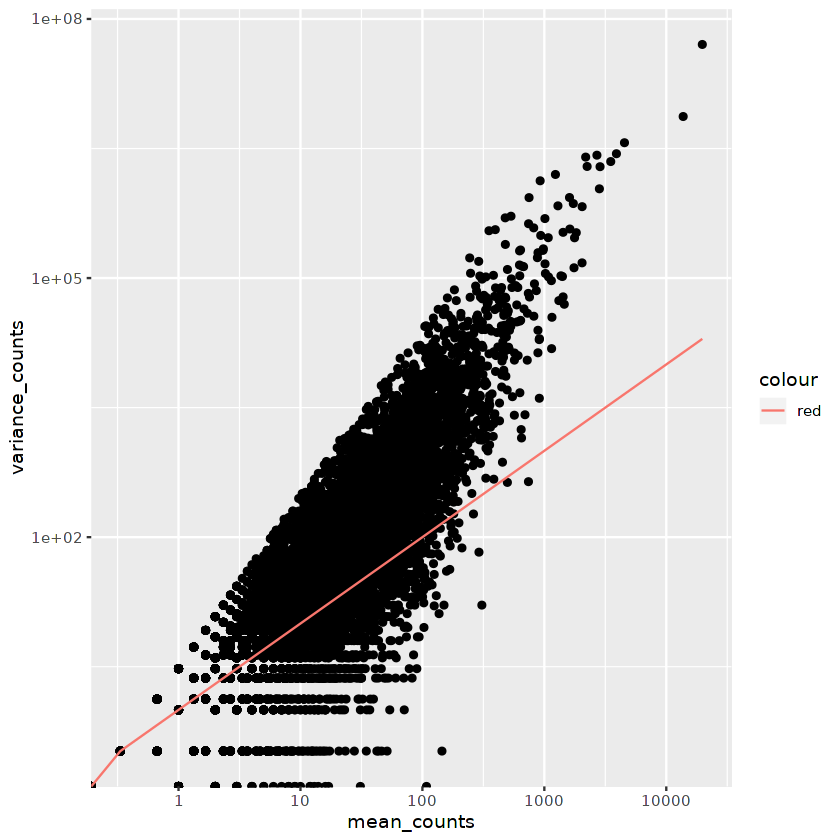

In [12]:
mean_counts <- apply(data[, 1:3], 1, mean)
variance_counts <- apply(data[, 1:3], 1, var)
df <- data.frame(mean_counts, variance_counts)
ggplot(df) +
        geom_point(aes(x=mean_counts, y=variance_counts)) + 
        geom_line(aes(x=mean_counts, y=mean_counts, color="red")) +
        scale_y_log10() +
        scale_x_log10()

Note that in the above figure, the variance across replicates tends to be greater than the mean (red line), especially for genes with large mean expression levels. This is a good indication that our data do not fit the Poisson distribution and we need to account for this increase in variance using the Negative Binomial model.
### **DESeq2 uses the negative binomial mode**

### Limma-Voom is another set of tools often used together for DE analysis, but this method may be less sensitive for small sample sizes. This method is recommended when the number of biological replicates per group grows large (> 20).

## 3. Normalization
### DESeq2 uses **median of ratios** for reads normalization. In this method, counts divided by sample-specific size factors determined by median ratio of gene counts relative to geometric mean per gene. This method takes sequencing depth and RNA composition into consideration, which is appropriate for DE analysis

### Count normalization using DESeq2

In [13]:
## match the metadata and counts data
all(colnames(data) %in% rownames(meta))

[1] TRUE

In [15]:
## Creat DESeq2Dataset object
dds <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ species)

In [16]:
## generate size factors
## By assigning the results back to the dds object we are filling in the slots of the DESeqDataSet object with the appropriate info
dds <- estimateSizeFactors(dds)

In [17]:
sizeFactors(dds)

Tml_1     Tml_2     Tml_3     Tms_1     Tms_2     Tms_3 
0.7574957 0.9654894 0.9764718 1.0846585 0.9694148 1.5338155

In [19]:
## retrieve the normalized counts matrix from dds
normalized_counts <- counts(dds, normalized=TRUE)

In [18]:
head(counts(dds))

,Tml_1,Tml_2,Tml_3,Tms_1,Tms_2,Tms_3
Tpr_TRINITY_DN11257_c2_g1|Tdu_TRINITY_DN16696_c0_g1,71,58,79,63,65,63
Tpr_TRINITY_DN10844_c2_g7|Tdu_TRINITY_DN25328_c2_g5,135,137,111,130,154,195
Tpr_TRINITY_DN15383_c4_g16|Tdu_TRINITY_DN14160_c0_g1,26,20,9,11,30,21
Tpr_TRINITY_DN1451_c0_g1|Tdu_TRINITY_DN16990_c3_g1,71,38,47,32,43,76
Tpr_TRINITY_DN10853_c1_g4|Tdu_TRINITY_DN21860_c3_g3,437,337,388,362,405,497
Tpr_TRINITY_DN12798_c2_g2|Tdu_TRINITY_DN24179_c2_g3,7,49,58,84,40,93


In [21]:
head(counts(dds, normalized=TRUE))

,Tml_1,Tml_2,Tml_3,Tms_1,Tms_2,Tms_3
Tpr_TRINITY_DN11257_c2_g1|Tdu_TRINITY_DN16696_c0_g1,93.729910,60.07316,80.903517,58.08280,67.05076,41.07404
Tpr_TRINITY_DN10844_c2_g7|Tdu_TRINITY_DN25328_c2_g5,178.218843,141.89695,113.674562,119.85339,158.85872,127.13393
Tpr_TRINITY_DN15383_c4_g16|Tdu_TRINITY_DN14160_c0_g1,34.323629,20.71488,9.216856,10.14144,30.94650,13.69135
Tpr_TRINITY_DN1451_c0_g1|Tdu_TRINITY_DN16990_c3_g1,93.729910,39.35828,48.132472,29.50237,44.35665,49.54964
Tpr_TRINITY_DN10853_c1_g4|Tdu_TRINITY_DN21860_c3_g3,576.900997,349.04578,397.348920,333.74558,417.77780,324.02854
Tpr_TRINITY_DN12798_c2_g2|Tdu_TRINITY_DN24179_c2_g3,9.240977,50.75146,59.397519,77.44373,41.26200,60.63311


## 4. Quality control
### 1) sample-level: assess overall similarity between samples, a.k.a. how well the samples/replicates cluster together
  - Principal Component Analysis (PCA)
  - Hierarchical Clustering Heatmap

### 2) gene-level: omit genes that have little or no chance of being detected as differentially expressed ==> increase the power to detect differentially expressed genes. **DESeq2 will perform this filtering by default**. The genes omitted fall into three categories:
  - Genes with 0 counts in all samples
  - Genes with an extreme count outlier
  - Genes with a low mean normalized counts

In [22]:
## Transform normalized counts using the rlog transformation
## The rlog transformation of the normalized counts is only necessary for these visualization methods during this quality assessment
## The blind=TRUE argument results in a transformation unbiased to sample condition information
rld <- rlog(dds, blind=TRUE)

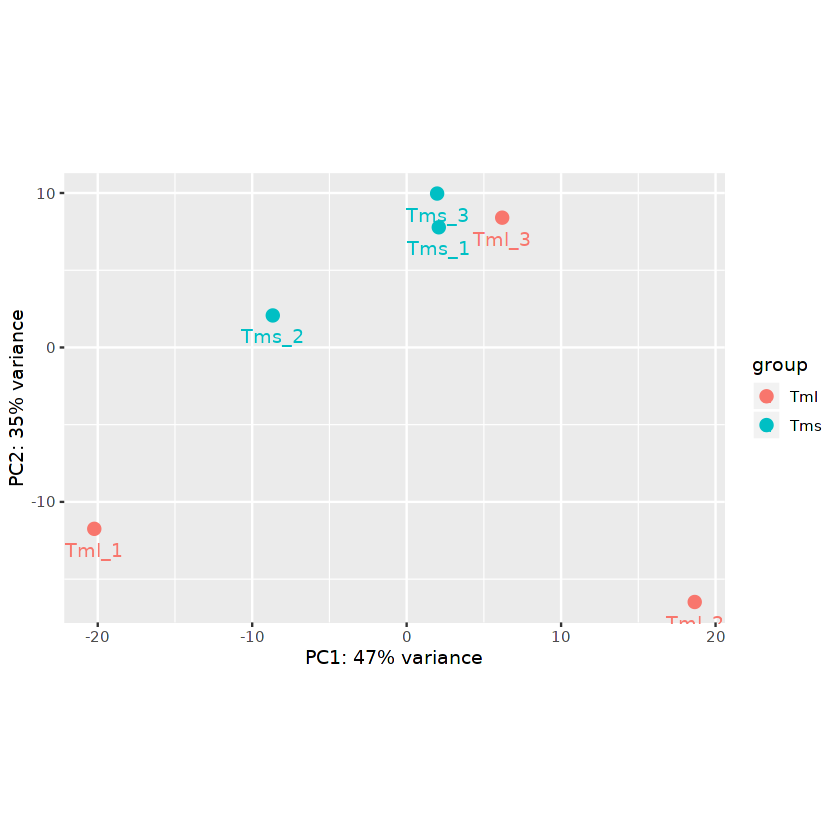

In [23]:
## Plot PCA
plotPCA(rld, intgroup="species") + geom_text(aes(label=name),vjust=2)

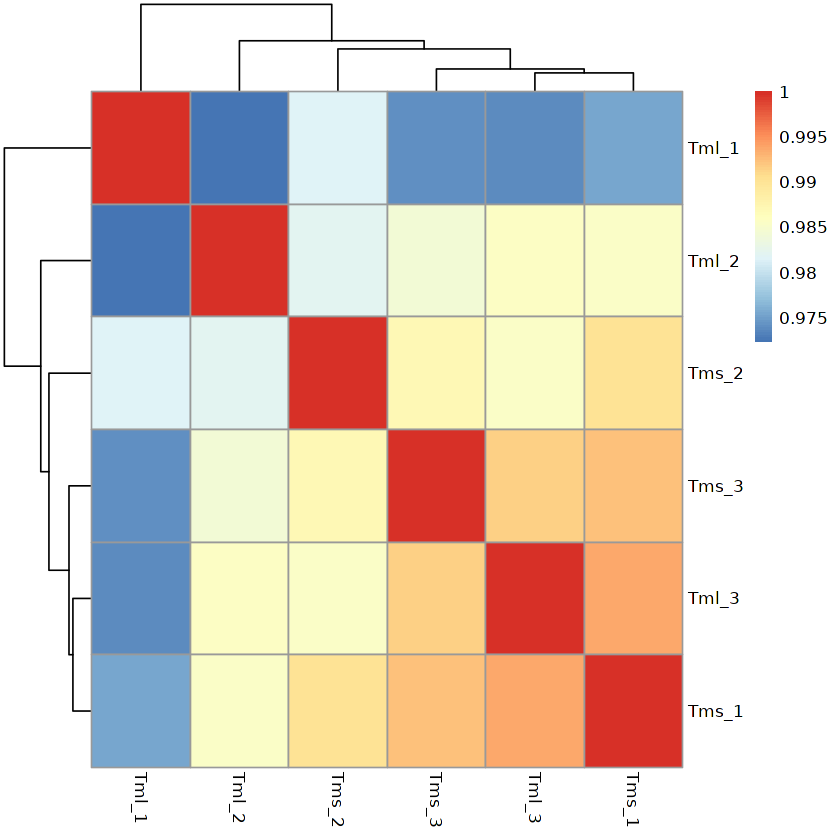

In [24]:
## Hierarchical clustering
## Extract the rlog matrix from the object
rld_mat <- assay(rld)
## Compute pairwise correlation values
rld_cor <- cor(rld_mat)
## Plot heatmap
pheatmap(rld_cor)

# Based on the quality control analysis, Tml_1 looks like a outlier. So, we decided to **romove Tml_1 before performing DE analysis**
## when including Tml_1, only 2 DE genes were identified between Tms and Tml (analysis not shown)